In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os #
from skimage import io 
from PIL import Image
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage import data, img_as_float
from skimage import exposure
import colorsys
import pickle

# Convert RGB to YIQ
def rgb_to_yiq(r, g, b):
    y = 0.30*r + 0.59*g + 0.11*b
    i = 0.60*r - 0.28*g - 0.32*b
    q = 0.21*r - 0.52*g + 0.31*b
    return (y, i, q)

#scikit-image -- https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

#scikit-image -- https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
def get_equal(img):
    
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

    # Equalization
    img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_rescale, img_eq, img_adapteq

In [2]:
# read dataset
path_no='complete_mednode_dataset\\naevus'
path_yes='complete_mednode_dataset\\melanoma'
can_im_list=[]
heal_im_list=[]
paths=[path_yes,path_no]
names=[]
for path in paths:
    for name in os.walk(path):
        names.append(name[2])
    
cancer=names[0]
healthy=names[1]
    
for image in cancer:
    can_im_list.append(Image.open(os.path.join(path_yes, image), 'r').resize((224,224)))

for image in healthy:
    heal_im_list.append(Image.open(os.path.join(path_no, image), 'r').resize((224,224)))

In [3]:
###------------naevi------------###
rescaled_heal_im_list=[]
eq_heal_im_list=[]
adapteq_heal_im_list=[]
iterator=0

for heal_image in heal_im_list: 
    Y=[]
    I=[]
    Q=[]
    image_array = np.array(heal_image)
    # normalization
    image_array=image_array/255
    
    # convert images' channels from RGB to YIQ
    yiq=np.zeros([224,224,3])
    for i in range(224):
        for j in range(224):
            a=rgb_to_yiq(image_array[i][j][0],image_array[i][j][1], image_array[i][j][2])
            Y.append(a[0])
            I.append(a[1])
            Q.append(a[2])

    Y=np.array(Y).reshape(224,224)
    I=np.array(I).reshape(224,224)
    Q=np.array(Q).reshape(224,224)

    # separately apply contrast stretching, histogram equalization and adapted histogram equalization to Y channel 
    img_rescale, img_eq, img_adapteq = get_equal(Y)
    
    ##--- reconstract images to RGB -----##
    # contrast stretching dataset
    img_rescale=np.array(img_rescale)
    rgb_rescale=np.zeros([224,224,3])
    for i in range(224):
        for j in range(224):
            loc=colorsys.yiq_to_rgb(img_rescale[i][j],I[i][j], Q[i][j])
            rgb_rescale[i][j][0]=(loc[0])
            rgb_rescale[i][j][1]=(loc[1])
            rgb_rescale[i][j][2]=(loc[2])
    rgb_rescale.reshape(150528,)
    rescaled_heal_im_list.append(rgb_rescale)
    
    # histogram equilization dataset
    img_eq=np.array(img_eq)
    rgb_eq=np.zeros([224,224,3])
    for i in range(224):
        for j in range(224):
            loc=colorsys.yiq_to_rgb(img_eq[i][j],I[i][j], Q[i][j])
            rgb_eq[i][j][0]=(loc[0])
            rgb_eq[i][j][1]=(loc[1])
            rgb_eq[i][j][2]=(loc[2])
    rgb_eq.reshape(150528,)
    eq_heal_im_list.append(rgb_eq)  
    
    # adapted histogram equilization dataset
    img_adapteq=np.array(img_adapteq)
    rgb_adapteq=np.zeros([224,224,3])
    for i in range(224):
        for j in range(224):
            loc=colorsys.yiq_to_rgb(img_adapteq[i][j],I[i][j], Q[i][j])
            rgb_adapteq[i][j][0]=(loc[0])
            rgb_adapteq[i][j][1]=(loc[1])
            rgb_adapteq[i][j][2]=(loc[2])
    rgb_adapteq.reshape(150528,)
    adapteq_heal_im_list.append(rgb_adapteq)

In [4]:
###---------------melanomas----------###
rescaled_can_im_list=[]
eq_can_im_list=[]
adapteq_can_im_list=[]
iterator=0

for can_image in can_im_list: 
    Y=[]
    I=[]
    Q=[]
    image_array = np.array(can_image)
    # normalization
    image_array=image_array/255

    # convert image channels from RGB to YIQ
    yiq=np.zeros([224,224,3])
    for i in range(224):
        for j in range(224):
            a=rgb_to_yiq(image_array[i][j][0],image_array[i][j][1], image_array[i][j][2])
            Y.append(a[0])
            I.append(a[1])
            Q.append(a[2])

    Y=np.array(Y).reshape(224,224)
    I=np.array(I).reshape(224,224)
    Q=np.array(Q).reshape(224,224)

    # separately apply contrast stretching, histogram equalization and adapted histogram equalization to Y channel  
    img_rescale, img_eq, img_adapteq = get_equal(Y)

    ##---- reconstract image to RGB -----##
    # contrast stretching dataset
    img_rescale=np.array(img_rescale)
    rgb_rescale=np.zeros([224,224,3])
    for i in range(224):
        for j in range(224):
            loc=colorsys.yiq_to_rgb(img_rescale[i][j],I[i][j], Q[i][j])
            rgb_rescale[i][j][0]=(loc[0])
            rgb_rescale[i][j][1]=(loc[1])
            rgb_rescale[i][j][2]=(loc[2])
    rgb_rescale.reshape(150528,)
    rescaled_can_im_list.append(rgb_rescale)

    # histogram equilization dataset
    img_eq=np.array(img_eq)
    rgb_eq=np.zeros([224,224,3])
    for i in range(224):
        for j in range(224):
            loc=colorsys.yiq_to_rgb(img_eq[i][j],I[i][j], Q[i][j])
            rgb_eq[i][j][0]=(loc[0])
            rgb_eq[i][j][1]=(loc[1])
            rgb_eq[i][j][2]=(loc[2])
    rgb_eq.reshape(150528,)
    eq_can_im_list.append(rgb_eq)  

    # adapted histogram equilization dataset
    img_adapteq=np.array(img_adapteq)
    rgb_adapteq=np.zeros([224,224,3])
    for i in range(224):
        for j in range(224):
            loc=colorsys.yiq_to_rgb(img_adapteq[i][j],I[i][j], Q[i][j])
            rgb_adapteq[i][j][0]=(loc[0])
            rgb_adapteq[i][j][1]=(loc[1])
            rgb_adapteq[i][j][2]=(loc[2])
    rgb_adapteq.reshape(150528,)
    adapteq_can_im_list.append(rgb_adapteq)

In [5]:
#----------create data dictionary---------#
dataMelanoma={
    'rescaled_heal_im_list' : rescaled_heal_im_list,
    'eq_heal_im_list' : eq_heal_im_list,
    'adapteq_heal_im_list': adapteq_heal_im_list,
    'rescaled_can_im_list' : rescaled_can_im_list,
    'eq_can_im_list' : eq_can_im_list,
    'adapteq_can_im_list': adapteq_can_im_list,    
}

In [6]:
# save processed images in pickle format
with open('dataMelanoma.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(dataMelanoma, f, pickle.HIGHEST_PROTOCOL)

------ original image ------


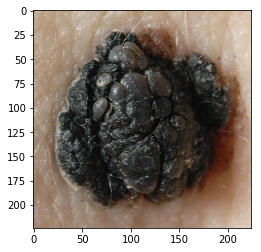



------ Y channel ------


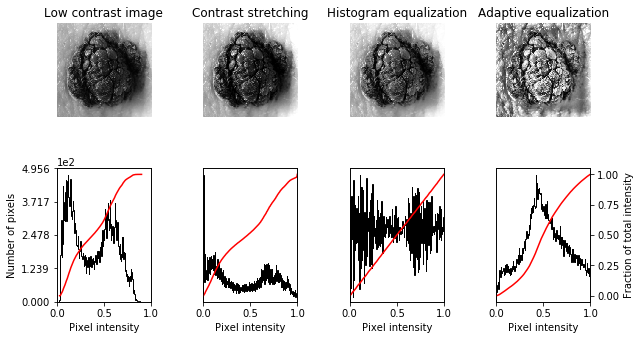

In [19]:
##------ display image's plots -------##
Y=[]
I=[]
Q=[]
image_lists = [heal_im_list,can_im_list]

# choose naevus [0,i] or melanoma [1,i] image
image_array = np.array(image_lists[1][0]) 
image_array=image_array/255
print("------ original image ------")
plt.imshow(image_array)
plt.show()
print("\n")

yiq=np.zeros([224,224,3])
for mpla in range(224):
    for aman in range(224):
        a=rgb_to_yiq(image_array[mpla][aman][0],image_array[mpla][aman][1], image_array[mpla][aman][2])
        Y.append(a[0])
        I.append(a[1])
        Q.append(a[2])

Y=np.array(Y).reshape(224,224)
I=np.array(I).reshape(224,224)
Q=np.array(Q).reshape(224,224)
print("------ Y channel ------")

# Load Y channel
img_rescale, img_eq, img_adapteq = get_equal(Y)

# Display results , scikit-image -- https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
fig = plt.figure(figsize=(9, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(Y, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()


plt.show()